# Loading a saved TF graph and apply it to a DataFrame

In [1]:
import findspark
findspark.init()

In [2]:
import pyspark
from pyspark import SparkContext
from pyspark.sql import SparkSession
sc = SparkContext()
spark = SparkSession(sc)

import numpy as np
import tensorflow as tf

%matplotlib inline
import matplotlib.pyplot as plt

This example loads the MNIST numpy arrays using the TensorFlow methods. 

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
(55000, 28, 28, 1)


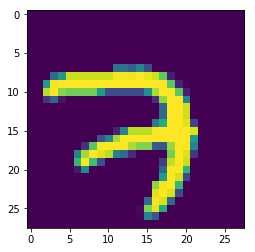

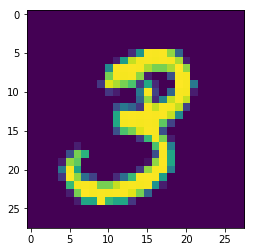

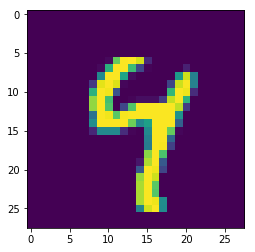

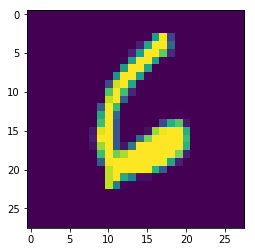

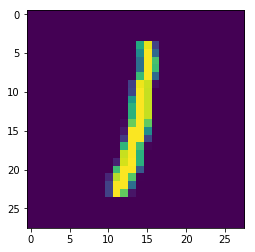

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data", one_hot=True)

X_train = np.reshape(mnist.train.images, (-1, 28, 28, 1))
y_train = np.asarray(mnist.train.labels, dtype=np.int32)

X_test = np.reshape(mnist.test.images, (-1, 28, 28, 1))
y_test = np.asarray(mnist.test.labels, dtype=np.int32)

print(X_train.shape)

for i in range(5):
    plt.imshow(X_train[i].squeeze())
    plt.show()

In [4]:
with tf.gfile.FastGFile('./saved_model/cnn_mnist.pb', 'rb') as f:
    model_graph = f.read()
    
model_graph_broadcasted = sc.broadcast(model_graph)

# Exercise

Create a function called `_apply_graph` to load the saved TensorFlow graph and apply it to an image. Have to get the input and output tensors from teh loaded graph definition and use those in `sess.run()` like normal TF convention. 

Hint: if you need to see the names of all the operations in the graph you can check them with 

```python
graph = tf.get_default_graph()
for i, op in enumerate(graph.get_operations()):
    print(i, op.name)
```

Hint 2: The images are held in the table as flattened vectors so they must be reshaped into (w,h,c) before running through the network. `data.reshape((-1,28,28,1)).

## Solution

In [22]:
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType

def _apply_graph(data):
    with tf.Graph().as_default() as graph:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(model_graph_broadcasted.value)
        
        tf.import_graph_def(graph_def, name='MNIST_CNN')
        
        X = graph.get_tensor_by_name('MNIST_CNN/input_placeholder/X:0')
        logits = graph.get_tensor_by_name('MNIST_CNN/cnn/output/logits_output:0')
        
        with tf.Session() as sess:
            preds = sess.run(tf.nn.softmax(logits), feed_dict={X: data.reshape((-1,28,28,1))})
            pred_val = tf.argmax(preds, 1).eval()
            
            #print(pred_val[0])
            return str(pred_val[0])
            
apply_graph = udf(_apply_graph)

In [6]:
_apply_graph(X_test[0])

7

In [7]:
from pyspark.ml.linalg import Vectors

# we'll take the first ten images from the numpy array to create a dataframe
dat = X_test[:10]
dat = dat.reshape((10, -1))
labels = np.argmax(y_test[:10], 1).reshape((10,-1))

dat = np.concatenate((labels, dat), axis=1)
print(dat.shape)

df = map(lambda x: (int(x[0]), Vectors.dense(x[1:])), dat)
mydf = spark.createDataFrame(df, schema=["label", "image"])
mydf.show()


(10, 785)
+-----+--------------------+
|label|               image|
+-----+--------------------+
|    7|[0.0,0.0,0.0,0.0,...|
|    2|[0.0,0.0,0.0,0.0,...|
|    1|[0.0,0.0,0.0,0.0,...|
|    0|[0.0,0.0,0.0,0.0,...|
|    4|[0.0,0.0,0.0,0.0,...|
|    1|[0.0,0.0,0.0,0.0,...|
|    4|[0.0,0.0,0.0,0.0,...|
|    9|[0.0,0.0,0.0,0.0,...|
|    5|[0.0,0.0,0.0,0.0,...|
|    9|[0.0,0.0,0.0,0.0,...|
+-----+--------------------+



In [23]:
from pyspark.sql.functions import udf

def test(a):
    return '55'

mytestUDF = udf(test)

mydf.withColumn('test', apply_graph('image')).show()

+-----+--------------------+----+
|label|               image|test|
+-----+--------------------+----+
|    7|[0.0,0.0,0.0,0.0,...|   7|
|    2|[0.0,0.0,0.0,0.0,...|   2|
|    1|[0.0,0.0,0.0,0.0,...|   1|
|    0|[0.0,0.0,0.0,0.0,...|   0|
|    4|[0.0,0.0,0.0,0.0,...|   4|
|    1|[0.0,0.0,0.0,0.0,...|   1|
|    4|[0.0,0.0,0.0,0.0,...|   4|
|    9|[0.0,0.0,0.0,0.0,...|   9|
|    5|[0.0,0.0,0.0,0.0,...|   5|
|    9|[0.0,0.0,0.0,0.0,...|   9|
+-----+--------------------+----+

